# Change in labor capacity

The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [5]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

import population_tools

In [6]:
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2



In [7]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }


MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.3 labour')
RESULTS_FOLDER.mkdir(exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'


In [8]:
WBGT_FOLDER = DATA_SRC / 'lancet' / 'wbgt'

## Plot the labour capacity function

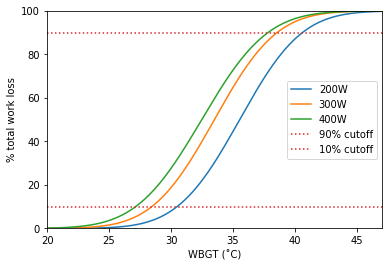

In [9]:
_wbgt = np.arange(20, 47, 0.1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W', color='C0')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W', color='C1')
                             
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W', color='C2')

plt.axhline(90, label='90% cutoff', color='C3', linestyle=':')
plt.axhline(10, label='10% cutoff', color='C3', linestyle=':')

plt.legend()


plt.ylim(0, 100)
plt.xlim(20, 47)

plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')

plt.savefig(RESULTS_FOLDER / 'labour_loss_function.png', dpi=300)
plt.savefig(RESULTS_FOLDER / 'labour_loss_function.pdf')

### Plot the clipped version

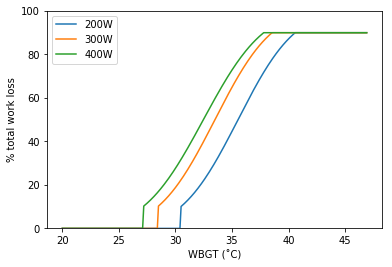

In [10]:
def _clip(lc):
    lc = xr.where(lc < 0.1, 0, lc)
    lc = xr.where(lc > 0.9, 0.9, lc)
    return lc

_wbgt = np.arange(20, 47, 0.1) + 273.15

labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
labourcapacity = _clip(labourcapacity)

plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W')

labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')
plt.ylim(0, 100)
plt.legend()

plt.savefig(RESULTS_FOLDER / 'labour_loss_function_clip.png', dpi=300)

# Open the generated datasets and combine

affected population for sector = population * working age fraction * fraction in sector

hours lost for sector = hours lost for power corresponding to sector * affector population for sector

hours lost total = sum of hours lost per sector across all sectors

### Assignment of sectors to work power levels

Once you have the cells proportioned between agriculture, industrial and service then you need to assign work loads to these sectors.  Clearly service sector would (on average) be about 200W and would be on average 300W with some areas (such as construction) going up to 400W, but other areas of industry (maybe clothing manufacture) being near 200W.  Agriculture is a problem, because some of this will be in the sun – which we haven’t quite got refined,  Some will be at 400W (hard work such as digging) while other work might be much less than this (berry or grape picking).  We use 400W in the shade as a ball-park average.


For a first approach, use the following simplified power assignement:


| Sector   | Power (W) |
|----------|-----------|
| Service  | 200       |
| Industry | 300       |
| Agri.    | 400       |     

In [11]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity'/ 'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

In [12]:
# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.groupby('time.year').sum(dim='time')
hours_lost_300 = hours_lost_300.groupby('time.year').sum(dim='time')
hours_lost_400 = hours_lost_400.groupby('time.year').sum(dim='time')


In [13]:
# Percentages for working age and employment distrubution
pct_working_age = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_working_age' / 'pct_working_age_*.nc'))

# Single file contains variables for each sector
pcts_in_emp = xr.open_dataset(DATA_SRC / 'lancet' /'labour_capacity' / 'era_30min_pcts' / 'employment_pcts_all_years.nc')

# yearly_pct_in_agri = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_agri' / 'pct_in_sector_*.nc'))
# yearly_pct_in_indu = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_indu' / 'pct_in_sector_*.nc'))
# yearly_pct_in_serv = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_serv' / 'pct_in_sector_*.nc'))

In [14]:
population = xr.open_dataarray(POPULATION_FILE)

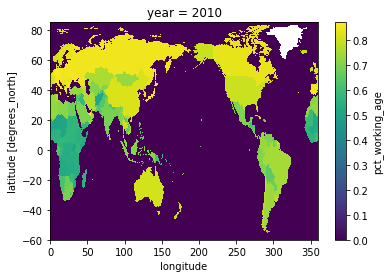

In [15]:
pct_working_age.sel(year=2010).pct_working_age.plot()

# Calculate the loss hours using population data

Loss hours = loss hours per person * % working age * total population

**NOTE**

When using the ILO data it is ALREADY GIVEN accounting for the % of working age (because its given as a % of the total population). So if you want to use the demographic gridded data for pct working age you have to FIRST factor it out of the total.

In [30]:
# IMPORTANT for this to work, need to first make sure PCT in SECTOR adds to 100%, doesn't already account for working population
# agri_weights = pct_working_age.pct_working_age * yearly_pct_in_agri.pct_in_sector
# indu_weights = pct_working_age.pct_working_age * yearly_pct_in_indu.pct_in_sector
# serv_weights = pct_working_age.pct_working_age * yearly_pct_in_serv.pct_in_sector
# agri_map = agri_weights * population * hours_lost_400.loss_hours
# indu_map = indu_weights * population * hours_lost_300.loss_hours
# serv_map = serv_weights * population * hours_lost_200.loss_hours

In [16]:
# When using the ILO data directly can skip to calculating the totals

working_population = pcts_in_emp * population *  pct_working_age.pct_working_age
# agri_map = working_population['agri'] * hours_lost_400.loss_hours
# indu_map = working_population['indu'] * hours_lost_300.loss_hours
# serv_map = working_population['serv'] * hours_lost_200.loss_hours

labour_losses = xr.Dataset({
    'agriculture': working_population['agri'] * hours_lost_400.loss_hours,
    'industry':working_population['indu'] * hours_lost_300.loss_hours,
    'service':working_population['serv'] * hours_lost_200.loss_hours
           })

In [29]:
years, datasets = zip(*labour_losses.groupby('year'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / 'labour_capacity_loss_2019_edition'/ f'loss_hours_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

In [26]:
total_loss_sectors = labour_losses.sum(dim=['latitude', 'longitude']).to_dataframe()
total_loss_sectors['total'] = total_loss_sectors.sum(axis=1)
total_loss_sectors

In [29]:
total_loss_sectors.to_excel(RESULTS_FOLDER/'total loss across sectors.xlsx')

# Plot the timeseries trend
Read previously saved results and plot

In [23]:
total_loss_sectors = pd.read_excel(RESULTS_FOLDER/'total loss across sectors.xlsx').set_index('year')

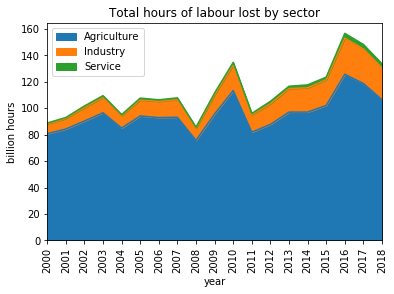

In [24]:
t = total_loss_sectors / 1_000_000_000
t.columns = t.columns.str.capitalize()

ax = t[['Agriculture', 'Industry', 'Service']].plot.area()
ax.set_ylabel('billion hours')

plt.title('Total hours of labour lost by sector')
# plt.xlim(2000, 2018)
plt.xticks(t.index, rotation=90);
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.png', bbox_inches='tight', dpi=300)
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.pdf', bbox_inches='tight')



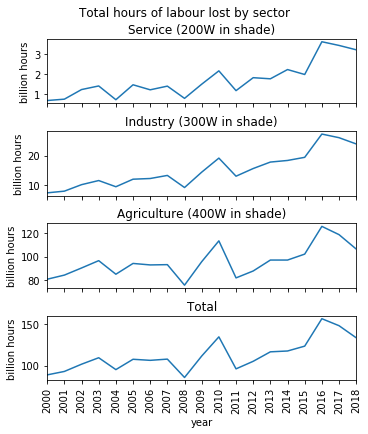

In [33]:
# Get values in billions
t = total_loss_sectors / 1_000_000_000

f, axs = plt.subplots(4,1, constrained_layout=True, sharex=True)
f.set_size_inches(5,6)
f.suptitle('Total hours of labour lost by sector')
ax = axs[0]
t.Service.plot(ax=ax)
ax.set_title('Service (200W in shade)')
ax.set_xlabel('')
ax.set_ylabel('billion hours')

ax = axs[1]
t.Industry.plot(ax=ax)
ax.set_title('Industry (300W in shade)')
ax.set_xlabel('')
ax.set_ylabel('billion hours')

ax = axs[2]
t.Agriculture.plot(ax=ax)
ax.set_title('Agriculture (400W in shade)')
ax.set_ylabel('billion hours')

ax = axs[3]
t.Total.plot(ax=ax)
ax.set_title('Total')
ax.set_ylabel('billion hours')

plt.xticks(total_loss_sectors.index, rotation=90);

plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector.png', bbox_inches='tight', dpi=300)
plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector.pdf', bbox_inches='tight')

# Map plots of loss hours

In [20]:
from cartopy import crs

#### 200W yearly loss hours per cell for 2000 and 2017

In [ ]:
year_vals = hours_lost_200.sel(year=[2000,MAX_YEAR]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'
p = year_vals.plot.pcolormesh(
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / f'200W 2000 to {MAX_YEAR} comparison.png', 
            bbox_inches='tight', dpi=300)

#### 300W yearly loss hours per cell for 2000 and 2017


In [ ]:
year_vals = hours_lost_300.sel(year=[2000,MAX_YEAR]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'

p = year_vals.plot.pcolormesh(
    vmin=0,
    vmax=700,
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / f'300W 2000 to {MAX_YEAR} comparison.png', 
            bbox_inches='tight', dpi=300)



#### 400W yearly loss hours per cell for 2000 and 2017


In [ ]:
year_vals = hours_lost_400.sel(year=[2000,MAX_YEAR]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'

p = year_vals.plot.pcolormesh(
    vmin=0,
    vmax=700,
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / f'400W 2000 to {MAX_YEAR} comparison.png', 
            bbox_inches='tight', dpi=300)

#### Change in labour loss at 400W

In [ ]:
loss_400_baseline = hours_lost_400.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).loss_hours.mean(dim='year')


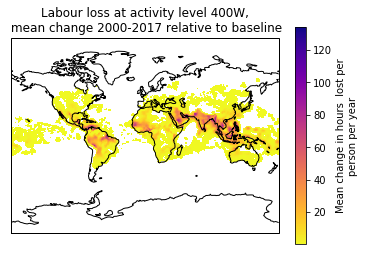

In [21]:
loss_deltas = hours_lost_400.loss_hours - loss_400_baseline


year_vals = loss_deltas.sel(year=slice(2000,2017)).mean(dim='year')
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Mean change in hours \nlost per person per year'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    cmap='plasma_r',
    transform=crs.PlateCarree(),
#     subplot_kws={'projection': crs.Miller()}
                         )
ax.coastlines()
plt.title('Labour loss at activity level 400W,\n mean change 2000-2017 relative to baseline')

#     for ax in p.axes.flat:
    
plt.savefig(RESULTS_FOLDER / '400W 2000 to 2017 mean delta.png', 
            bbox_inches='tight', dpi=600)

plt.savefig(RESULTS_FOLDER / '400W 2000 to 2017 mean delta.pdf', 
            bbox_inches='tight', dpi=600)

### Total loss in hours, not accounting for activity level

In [7]:
hours_lost_total = hours_lost_400 + hours_lost_300 + hours_lost_200

In [ ]:
loss_total_baseline = hours_lost_total.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).loss_hours.mean(dim='year')


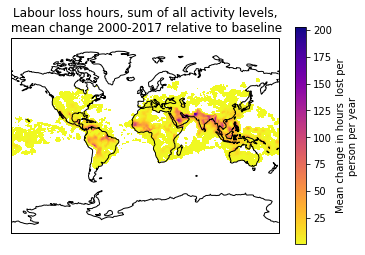

In [31]:
loss_deltas = hours_lost_total.loss_hours - loss_total_baseline


year_vals = loss_deltas.sel(year=slice(2000,2017)).mean(dim='year')
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Mean change in hours \nlost per person per year'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    cmap='plasma_r',
    transform=crs.PlateCarree(),
#     subplot_kws={'projection': crs.Miller()}
                         )
ax.coastlines()
plt.title('Labour loss hours, sum of all activity levels,\n mean change 2000-2017 relative to baseline')

#     for ax in p.axes.flat:
    
plt.savefig(RESULTS_FOLDER / 'total powers 2000 to 2017 mean delta.png', 
            bbox_inches='tight', dpi=300)

In [11]:
total_loss_sectors / 1e9

Agriculture   Industry   Service       Total
year                                              
2000    80.857130   7.358398  0.687311   88.902839
2001    84.352387   7.933051  0.754653   93.040090
2002    90.419620  10.132728  1.232411  101.784759
2003    96.668941  11.527410  1.411360  109.607711
2004    85.128939   9.426372  0.727467   95.282778
2005    94.322431  11.979165  1.470270  107.771865
2006    93.067107  12.217339  1.218137  106.502583
2007    93.311481  13.260914  1.398429  107.970823
2008    75.830135   9.161652  0.791055   85.782842
2009    95.855905  14.372717  1.494029  111.722651
2010   113.608058  19.139184  2.156298  134.903540
2011    82.060016  13.009602  1.173157   96.242775
2012    87.997347  15.609558  1.817646  105.424551
2013    97.308165  17.802522  1.762381  116.873069
2014    97.328277  18.347305  2.221864  117.897445
2015   102.390092  19.409768  1.975526  123.775386
2016   126.025535  27.302082  3.600558  156.928175
2017   119.026474  26.069357  3.415049  148.510880
2018   106.822323  23.968691  3.197898  133.988913